In [146]:
import requests
import inspect
import pytz
import pandas as pd
import numpy as np

from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import (YEARLY, DateFormatter,rrulewrapper, RRuleLocator, drange)
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from time import ctime   # ctime converts epoch time (ex:1661522400) to string form (Thu Aug 25 16:00:00 2022)
from time import gmtime   # Convert a time expressed in seconds since the epoch to a struct_time in UTC in which the dst flag is always zero.
from time import localtime # Like gmtime() but converts to local time.

from datetime import datetime, timedelta
today = datetime.now()
import datetime as dt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 20




### 2 fichiers créés par node-red et mis à jour toutes les heures avec openweather node dans onglet Temp/Hum

#### json_file ="C:/Users/jean/OneDrive/Bureau/5days.txt"

#### json_file ="Y:/Documents/5days.txt"

#### le fichier contient une liste de 40 lignes :
- une ligne = 3 heures, 
- 8 lignes par jour 
- sur 5 jours


In [147]:
try:
    json_file = "Y:/Documents/5days.txt"  # pc cuisine
    current = pd.read_json(json_file)
except:
    json_file = "Z:/Documents/5days.txt"  # pc chambre
    current = pd.read_json(json_file)

In [148]:
#current['dates'] = [datetime.fromtimestamp(current.dt[k], pytz.timezone('Europe/Paris')) for k in range(40)]
current['dates'] = [datetime.fromtimestamp(current.dt[k]) for k in range(40)]
current['h_date'] = [datetime.fromtimestamp(current.dt[k]).strftime('%d/%m/%Y %H:%M:%S') for k in range(40)]
current['h_time'] = [datetime.fromtimestamp(current.dt[k]).strftime('%H') for k in range(40)]
current


,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,temp_kf,dt,dates,h_date,h_time
0,9.25,7.39,9.25,10.12,1026,1026,1017,90,-0.87,1715148000,2024-05-08 08:00:00,08/05/2024 08:00:00,08
1,13.20,12.46,13.20,15.39,1027,1027,1018,72,-2.19,1715158800,2024-05-08 11:00:00,08/05/2024 11:00:00,11
2,18.98,18.21,18.98,18.98,1027,1027,1017,49,0.00,1715169600,2024-05-08 14:00:00,08/05/2024 14:00:00,14
3,19.53,18.82,19.53,19.53,1026,1026,1016,49,0.00,1715180400,2024-05-08 17:00:00,08/05/2024 17:00:00,17
4,15.66,15.06,15.66,15.66,1027,1027,1018,68,0.00,1715191200,2024-05-08 20:00:00,08/05/2024 20:00:00,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,22.92,22.63,22.92,22.92,1010,1010,1001,52,0.00,1715526000,2024-05-12 17:00:00,12/05/2024 17:00:00,17
36,20.16,20.32,20.16,20.16,1010,1010,1001,80,0.00,1715536800,2024-05-12 20:00:00,12/05/2024 20:00:00,20
37,18.18,18.40,18.18,18.18,1010,1010,1000,90,0.00,1715547600,2024-05-12 23:00:00,12/05/2024 23:00:00,23
38,16.35,16.50,16.35,16.35,1008,1008,999,94,0.00,1715558400,2024-05-13 02:00:00,13/05/2024 02:00:00,02


In [149]:
debut = current.head(1).h_date[0]
fin = current.tail(1).h_date[39]
debut, fin

('08/05/2024 08:00:00', '13/05/2024 05:00:00')

<Axes: >

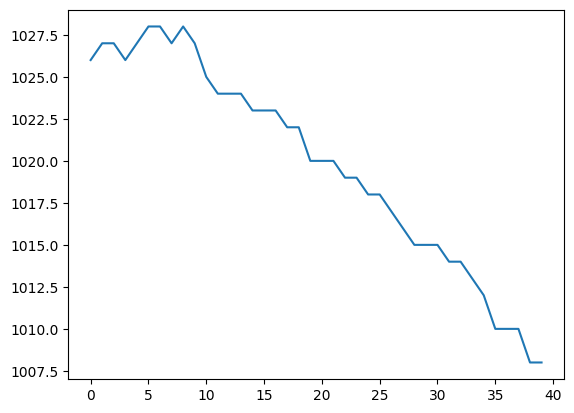

In [150]:
(current.pressure).plot()


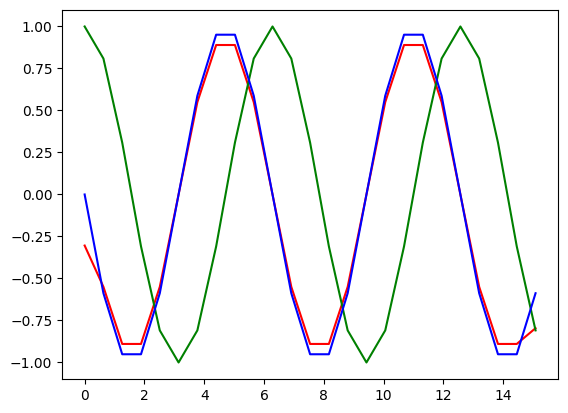

In [151]:
pi = np.pi
x = np.arange(0,5*pi,0.2*pi)
y = np.cos(x) 
# derivative dy/dx = -sin(x)
der = np.gradient(y,x)
plt.plot(x, der, 'r', x, y, 'g', x, -np.sin(x),'b')
plt.show()

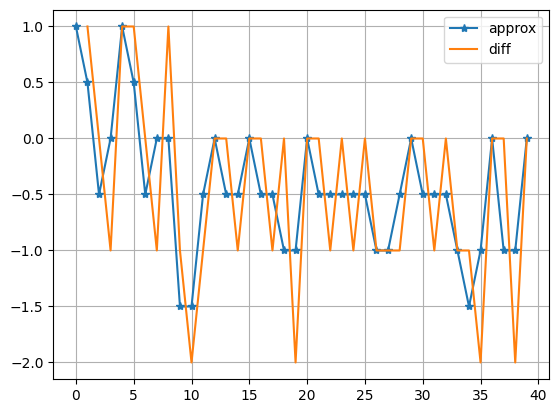

In [152]:
# derivative of pressure
dy = current.pressure#.diff()
#dy.plot()
# we sample a sin(x) function
dx = current.index.step
x = np.arange(0,40)
#current.pressure.diff().plot(label='diff')
# we calculate the derivative, with np.gradient
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
#plt.plot()
dy.diff().plot(x=x,label='diff')
plt.legend()
plt.grid()


In [153]:
dy.diff()

0     NaN
1     1.0
2     0.0
3    -1.0
4     1.0
     ... 
35   -2.0
36    0.0
37    0.0
38   -2.0
39    0.0
Name: pressure, Length: 40, dtype: float64

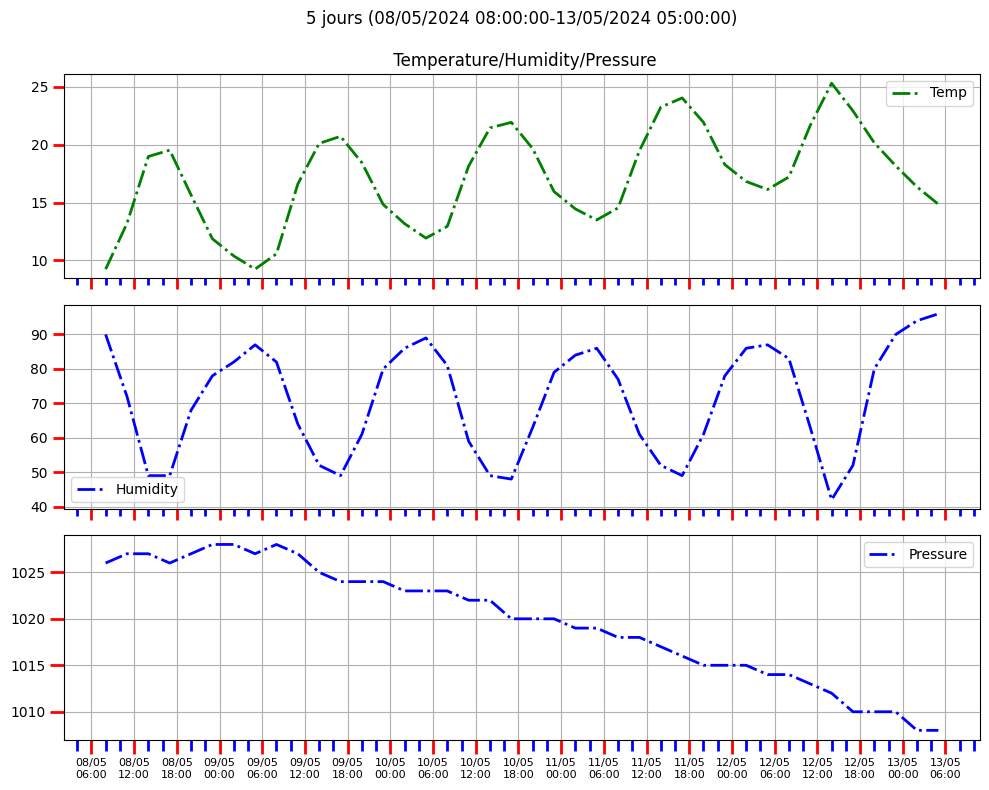

In [154]:
#fig, (ax1,ax2,ax3) = plt.subplots(3,1)
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True)
# the size of A4 paper
fig.set_size_inches(10, 8)

ax1.tick_params('x', labelsize=8)
ax2.tick_params('x', labelsize=8)
ax3.tick_params('x', labelsize=8)

# format affichage dates sur axe des x
formatter = DateFormatter('%d/%m\n%H:%M')
#ax1.xaxis.set_major_formatter(formatter)
#ax2.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_formatter(formatter)

# nombre de ticks sur axe des x
major_ticks = 1/4                    # toutes les 6 heures pour 1/4, 12h pour 1/2
minor_ticks = major_ticks/3          # facteur div = 4  -> minor ticks toutes les 3 heures

# temperature
ax1.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax1.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  # ???? pas d'affichage des minor ticks ???
# format des ticks
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=8, color='r')
ax1.tick_params(which='minor', length=5, color='b')
#plot
ax1.plot(current.dates,current.temp,'g-.',label='Temp',linewidth=2)
#plt.plot(current.dates,current.temp_max,'r-.',label='Max',linewidth=2)
#plt.plot(current.dates,current.temp_min,'b-.',label='Min',linewidth=2)

# humidity
ax2.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax2.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8, color='r')
ax2.tick_params(which='minor', length=5, color='b')
ax2.plot(current.dates,current.humidity,'b-.',label='Humidity',linewidth=2)

# pression
ax3.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax3.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=10, color='r')
ax3.tick_params(which='minor', length=8, color='b')
ax3.plot(current.dates,current.pressure,'b-.',label='Pressure',linewidth=2)

ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
ax3.grid()
ax3.legend()

ax1.set_title(f'5 jours ({debut}-{fin})\n\n Temperature/Humidity/Pressure')
#ax2.set_title(f'Humidity')
fig.tight_layout()


# tendances

## temp * pression / humidity
- plus de pression, moins d'humidité = meilleure tendance

In [155]:
'''Le point de rosée est une donnée thermodynamique caractérisant l'humidité dans un gaz. 
Le point de rosée de l'air est la température à laquelle la pression partielle de vapeur 
d'eau est égale à sa pression de vapeur saturante. Il s'agit donc de la température à 
laquelle il faut refroidir un volume d'air, à pression et humidité absolue constantes, 
pour qu'il devienne saturé donc il y a condensation.

La dépression du point de rosée est la différence entre la température et le point de rosée : (T-Tr)
 à un niveau de pression donnée de l'atmosphère terrestre
'''
import numpy as np
a, b = 17.27, 237.7

def alpha(T,phi):
    '''
    0 < T < 60
    0.01 < phi < 1
    '''
    return a*T/(b+T) + np.log(phi)

def dewpoint(T, phi): # phi : humidité relative
    f = alpha(T,phi)
    Tr = b*f/(a-f)
    return (T,Tr,T-Tr) #round(Tr,2), round(T-Tr,2)   # dewpoint, depression


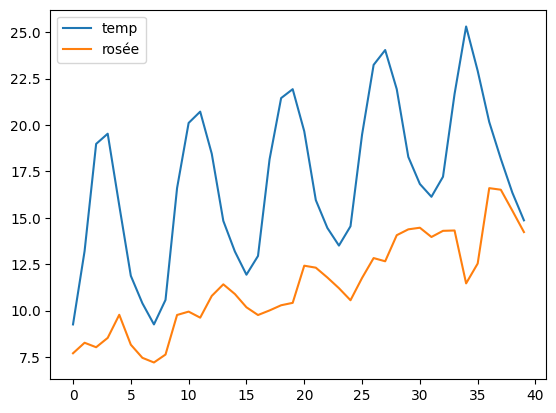

In [156]:
x = np.arange(40)
x_temp = current.temp
x_hum = current.humidity/100

rosee = dewpoint(x_temp,x_hum)
plt.plot(x,x_temp,label='temp')
plt.plot(x,rosee[1],label='rosée')
plt.legend()


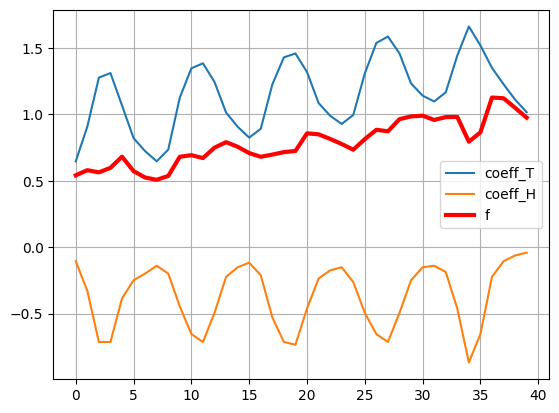

In [157]:
y_temp = a*x_temp/(b+x_temp)
y_hum = np.log(x_hum)
plt.plot(x,y_temp,label='coeff_T')
plt.plot(x,y_hum,label='coeff_H')  # valeurs négatives
f = y_temp+y_hum  # alpha()
plt.plot(x,f,label='f',lw=3,c='red')
plt.grid()
plt.legend()


(237.7, 17.27)

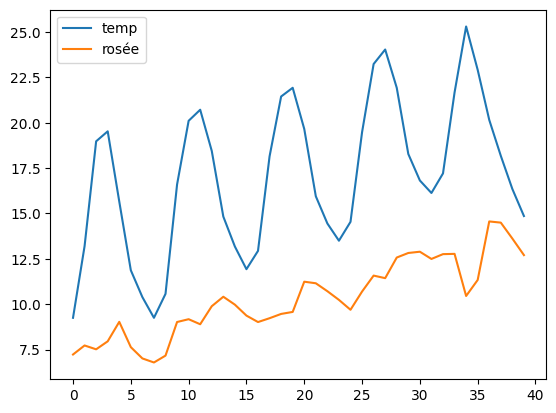

In [158]:
plt.plot(x,x_temp,label='temp')
plt.plot(x,b*f/(a+f),label='rosée')
plt.legend()
b,a


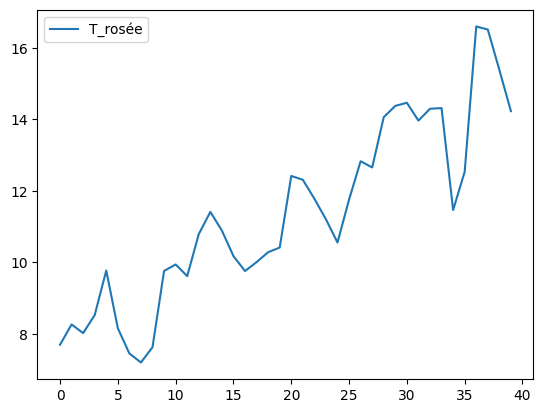

In [159]:
plt.plot(x,b*f/(a-f),label='T_rosée')
plt.legend()

In [160]:

f = y_temp+y_hum
f, alpha(y_temp,x_hum)


(0     0.541521
 1     0.580081
 2     0.563667
 3     0.597862
 4     0.681784
         ...   
 35    0.864869
 36    1.127059
 37    1.121654
 38    1.049577
 39    0.975302
 Length: 40, dtype: float64,
 0    -0.058489
 1    -0.262743
 2    -0.621065
 3    -0.618607
 4    -0.308454
         ...   
 35   -0.544280
 36   -0.125599
 37   -0.016670
 38    0.018501
 39    0.032690
 Length: 40, dtype: float64)

In [161]:
(x,y_hum)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 0    -0.105361
 1    -0.328504
 2    -0.713350
 3    -0.713350
 4    -0.385662
         ...   
 35   -0.653926
 36   -0.223144
 37   -0.105361
 38   -0.061875
 39   -0.040822
 Name: humidity, Length: 40, dtype: float64)

In [162]:
dewpoint(current.temp[0],current.humidity[0]/100)

(9.25, 7.694641617885705, 1.555358382114295)

In [163]:
dewpt = dewpoint(current.temp ,current.humidity/100) 
dewpt

(0      9.25
 1     13.20
 2     18.98
 3     19.53
 4     15.66
       ...  
 35    22.92
 36    20.16
 37    18.18
 38    16.35
 39    14.86
 Name: temp, Length: 40, dtype: float64,
 0      7.694642
 1      8.261590
 2      8.019926
 3      8.523913
 4      9.769587
         ...    
 35    12.531402
 36    16.595606
 37    16.510501
 38    15.380886
 39    14.227279
 Length: 40, dtype: float64,
 0      1.555358
 1      4.938410
 2     10.960074
 3     11.006087
 4      5.890413
         ...    
 35    10.388598
 36     3.564394
 37     1.669499
 38     0.969114
 39     0.632721
 Length: 40, dtype: float64)

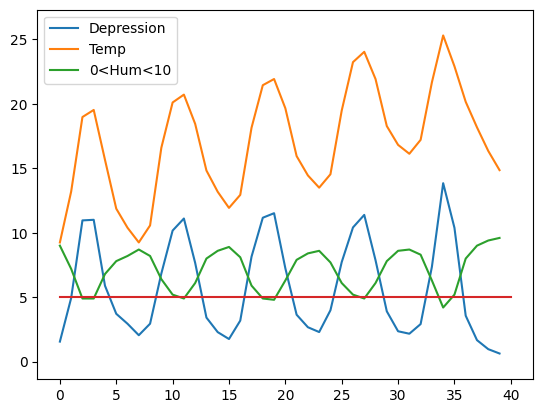

In [164]:
plt.plot(dewpt[2],label='Depression')
plt.plot(current.temp,label='Temp')
plt.plot(current.humidity/10,label='0<Hum<10')
plt.plot((0,40),(5,5))
plt.ylim(min(dewpt[2])-2,max(current.temp)+2)
plt.legend()
plt.show()


In [165]:
current.temp.head(),current.h_time.head()

(0     9.25
 1    13.20
 2    18.98
 3    19.53
 4    15.66
 Name: temp, dtype: float64,
 0    08
 1    11
 2    14
 3    17
 4    20
 Name: h_time, dtype: object)

In [166]:
current['dew_point'] = dewpt[1]
current[['h_time','temp','dew_point']]

,h_time,temp,dew_point
0,08,9.25,7.694642
1,11,13.20,8.261590
2,14,18.98,8.019926
3,17,19.53,8.523913
4,20,15.66,9.769587
...,...,...,...
35,17,22.92,12.531402
36,20,20.16,16.595606
37,23,18.18,16.510501
38,02,16.35,15.380886


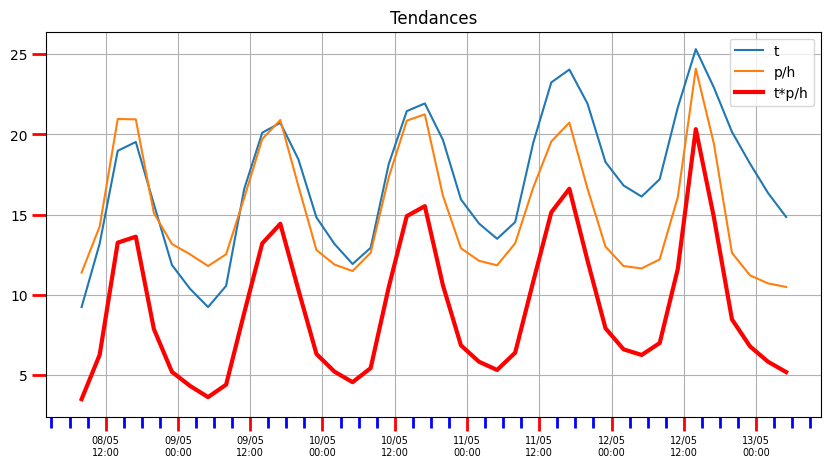

In [167]:
result1=current.temp  #*current.humidity*current.pressure
result2=(current.pressure)/(current.humidity*10)  #p/h est normalisé, on ramène le rapport autour de 1
result3=(current.temp)*result2

fig, ax = plt.subplots()

# nombre de ticks sur axe des x
major_ticks = 1/2                   # toutes les 6 heures pour 1/4, 12h pour 1/2, 3 heures pour 1/8
minor_ticks = major_ticks/4          # denominateur n = n minor ticks 


# format grid
fig.set_size_inches(10, 5)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.tick_params('x', labelsize=7)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10, color='r')
ax.tick_params(which='minor', length=8, color='b')

# plot
plt.plot(current.dates, result1,label='t')
plt.plot(current.dates, result2*10,label='p/h')
plt.plot(current.dates, result3/3,label='t*p/h',lw=3,c='red')
plt.legend()
plt.title('Tendances')
plt.grid()

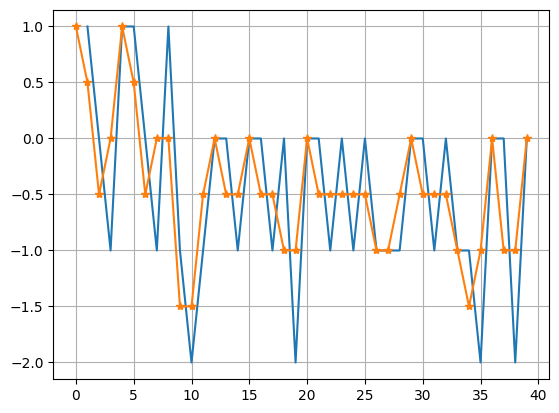

In [168]:
dy.diff().plot()
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
plt.grid()

In [169]:
len(dy)

40

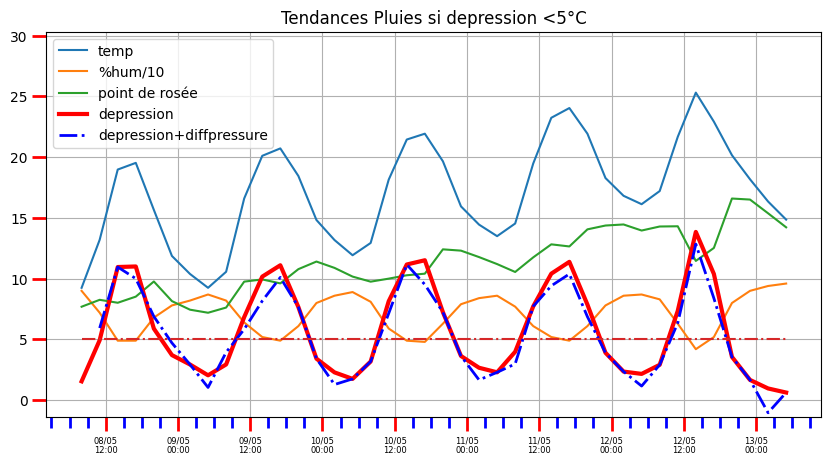

In [170]:
temp = current.temp  
# point de rosée
current['dewpoint']=dewpt[1]
point_rosee = dewpt[1]
# calcul de la dépression
depression = current.temp-point_rosee
current['depression']=depression
fig, ax = plt.subplots()

# format grid
fig.set_size_inches(10, 5)
# graduations axeX
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.tick_params('x', labelsize=6)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10, color='r')
ax.tick_params(which='minor', length=8, color='b')

# plot
plt.plot(current.dates, temp,label='temp')
plt.plot(current.dates, current.humidity/10,label='%hum/10')
plt.plot(current.dates, point_rosee,label='point de rosée')#,lw=3,c='red')
# tendances pluie
#lbl = 'depr<5+ "pluie" if depression[0]<5 else ""
plt.plot(current.dates, depression,label="depression",lw=3,c='red')
plt.plot(current.dates, depression+dy.diff(),'-.',label="depression+diffpressure",lw=2,c='blue')
plt.plot((current.dates[0],current.dates[39]),(5,5),'-.')

plt.ylim(min(depression)-2,max(current.temp)+5)
plt.legend()
plt.title('Tendances Pluies si depression <5°C')
plt.grid()


In [171]:
datetime.now().strftime('%d/%m/%Y %H:%M:%S')

'08/05/2024 06:29:42'

In [172]:
current['tendances']=current['depression'].apply(lambda x: 'pluie' if x<5 else 'beau temps')
# 24 h
current[:20][['h_date','temp','depression','tendances']]

,h_date,temp,depression,tendances
0,08/05/2024 08:00:00,9.25,1.555358,pluie
1,08/05/2024 11:00:00,13.20,4.938410,pluie
2,08/05/2024 14:00:00,18.98,10.960074,beau temps
3,08/05/2024 17:00:00,19.53,11.006087,beau temps
4,08/05/2024 20:00:00,15.66,5.890413,beau temps
5,08/05/2024 23:00:00,11.87,3.713736,pluie
6,09/05/2024 02:00:00,10.39,2.940170,pluie
7,09/05/2024 05:00:00,9.25,2.051664,pluie
8,09/05/2024 08:00:00,10.57,2.944413,pluie
9,09/05/2024 11:00:00,16.60,6.841350,beau temps


In [173]:
current[20:40][['h_date','temp','depression','tendances']]

,h_date,temp,depression,tendances
20,10/05/2024 20:00:00,19.66,7.244938,beau temps
21,10/05/2024 23:00:00,15.95,3.641405,pluie
22,11/05/2024 02:00:00,14.45,2.671779,pluie
23,11/05/2024 05:00:00,13.50,2.297181,pluie
24,11/05/2024 08:00:00,14.54,3.986889,pluie
25,11/05/2024 11:00:00,19.48,7.724944,beau temps
26,11/05/2024 14:00:00,23.24,10.413615,beau temps
27,11/05/2024 17:00:00,24.04,11.386866,beau temps
28,11/05/2024 20:00:00,21.93,7.870575,beau temps
29,11/05/2024 23:00:00,18.28,3.905461,pluie


In [174]:
current.h_date

0     08/05/2024 08:00:00
1     08/05/2024 11:00:00
2     08/05/2024 14:00:00
3     08/05/2024 17:00:00
4     08/05/2024 20:00:00
             ...         
35    12/05/2024 17:00:00
36    12/05/2024 20:00:00
37    12/05/2024 23:00:00
38    13/05/2024 02:00:00
39    13/05/2024 05:00:00
Name: h_date, Length: 40, dtype: object